# TP 4: Compression

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
from numpy.fft import fft, ifft, fftshift
from playsound import playsound
from IPython.display import display, Audio

## TFCT

In [76]:
#Question 3 

def tfct(x, Nwin, Nhop, Nfft, fe):
    
    L=int((len(x)-Nwin)/Nhop) +1 ;M=Nfft # L nombre de trame à extraire dans xvect une partie du signal
    # M nombre minimal de points fréquentiels utiles pour chaque spectre
    #L2=int((len(x)/Nwin)*2-1)
    xmat=np.zeros((M,L))        # initialisation de la matrice xmat de taille Mx
    sigMat = []
    colonne=0
    i=0
    hamming=np.hamming(Nwin)  # fenetre de hamming de taille Nwin

    while (int(i+Nwin)<=int(len(x))): 
        for j in range(int(i),int(i+Nwin)):
            sigMat.append(x[j])  #on recupere la trame correpondant i+Nwin trame
        
            
        TFD=np.fft.fft(sigMat*hamming)  # on multiplie notre fenetre par les Nfft points de notre signal xx
        xmat[:,colonne]=abs(TFD)
        colonne+=1  # on incremente la variable qui change les collonnes de la matrice Xmat
        i=i+Nhop   # on déclale d'une demi trame, soit le pas d'avancement Nhop 
        sigMat=[] # on efface la trame ancienne
        
    
    f=np.linspace(0,fe,Nfft)
    t=np.linspace(0,len(x)/fe,Nfft)
        
    print(M,L)
    return xmat[0:int(Nfft/2+1),:],t,f 
  

## QST 1:  TFCT d'un audio x: 

ipykernel_launcher:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
la fréquence d'échantillonnage du signal:  44100


1024 923
ipykernel_launcher:19: RuntimeWarning: divide by zero encountered in log10


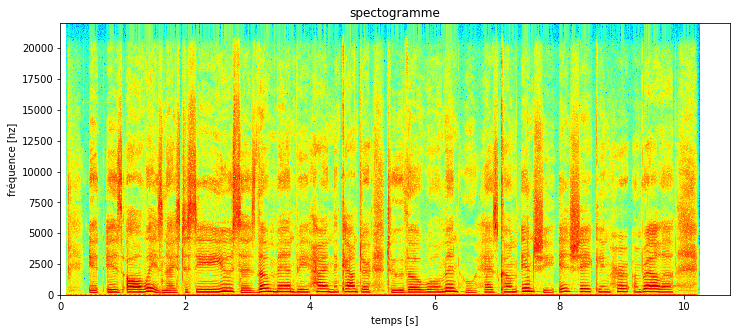

In [79]:
Nwin = 1024
Nfft = Nwin
Nhop = Nwin//2 # pas d'avancement de chaque trame.

fe,xvect=wav.read("suzanneVega_tomsDiner.wav")
print("la fréquence d'échantillonnage du signal: ",fe)

display(Audio(xvect,rate=fe))

#----tracé du spectogramme:
# normaliser le signal xvect:
x=xvect/max(abs(xvect))

xmat,temps,freq=tfct(x,Nwin,Nhop,Nfft,fe)


plt.figure(figsize=(12,5))
plt.title("spectogramme")
plt.imshow(20*np.log10(xmat),aspect ='auto', origin='lower',cmap='jet',extent=(0,temps[-1],0,freq[-1]//2))
plt.xlabel('temps [s]')
plt.ylabel("fréquence [hz]")
plt.show()

## QST 2: 

In [8]:
A= np.zeros(xmat.shape[1]) # le facteur de gain
for i in range (xmat.shape[1]):
    A[i]=max(abs(xmat[:,i]))
    
print("facteur de gains An:\nles 5 première trames\n",A[0:50])

facteur de gains An:
les 5 première trames
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.10910347e+02 5.87295563e+05 5.13242389e+06
 5.25554333e+06 1.82041891e+06 5.51967022e+05 5.24843903e+05
 7.84175536e+05 1.18803722e+06]


## QST 3: 

In [9]:
debit = 392000
nb_par_trame= debit/(fe/Nwin)
bit_par_trame=np.floor(nb_par_trame)
print("le nombre bit par chaque trame : ", bit_par_trame)

nb_par_point_freq=bit_par_trame/Nwin
bit_par_point=np.floor(nb_par_point_freq)
print("le nombre de bit par point frequenciel : ", bit_par_point)

le nombre bit par chaque trame :  9102.0
le nombre de bit par point frequenciel :  8.0


## QST 4:

In [10]:
### fonction de quantification
def quantif(X, A, N):#(input sig, full-scall value, Number of bites)
    X = np.float64(X)
    high = A
    low = -1*A
    q = (high-low)/(2**N)
    Q = np.max(np.array([np.min(np.array([np.floor((X-low)/q), np.ones_like(X)*(2**N-1)]), axis = 0), np.zeros_like(X)]), axis = 0)
    low = low + q/2
    Y = low + q*Q
    return Y, q, Q #(quantization output, quant step, quantizd value (between 0 and 2^log2(N)-1))

In [92]:
# convertir xmat en dB:
xmat_dB=np.zeros(xmat.shape)

for i in range(xmat.shape[0]):         # parcourir les trames
    for j in range(xmat.shape[1]):     # parcourir les points fréq
        if xmat[i,j]==0:
            xmat_dB[i,j]=1              # ces points ne vont pas être 
        elif xmat[i,j]>0:
            xmat_dB[i,j]=20*np.log(xmat[i,j])   #en dB 

# initialisatin:
nbits_trame=0
xmat_compress=np.zeros(xmat.shape)

# SMR :
SMR=np.zeros(xmat.shape)
for i in range(xmat.shape[0]):         # parcourir les trames
    for j in range(xmat.shape[1]):     # parcourir les points fréq
        if xmat[i,j]==0:
            SMR[i,j]=1                # ces points ne vont pas être codé N=0
        elif xmat[i,j]>0: 
            SMR[i,j]=20*np.log(abs(xmat[i,j]))-96  #en dB 

R=bit_par_trame
Q=np.zeros(xmat.shape)

In [94]:
for i in range (xmat.shape[1]):           # parcourir les trames
    for j in range(xmat.shape[0]):        # parcourir les points fréqentiels
        N=1
        SNR=0
        NMR=1
        if xmat[j,i]==0:
            Q[j,i]=0
            continue
        else:
            while ((R>0 or NMR>0 )and N<24):
                X=xmat_dB[j,i]                   # point fréquentiel
                A=max(abs(xmat[:,i]))         # pleine échelle
                NMR=SMR[j,i]-SNR
                Q[j,i]+=1
                SNR+=6
                R-=1  
                

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(20*np.log10(abs(xmat_compress)),aspect ='auto', origin='lower',cmap='rainbow',extent=(0,temps[-1],0,freq[-1]//2))
plt.show()

print(Q[:,50])
print(xmat_dB[:,50])

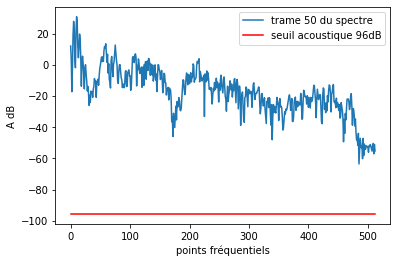

In [90]:
acoustique=np.zeros(xmat.shape[0])
acoustique=acoustique-96

plt.figure()
plt.plot(20*np.log10(xmat[:,130]),label='trame 50 du spectre')
plt.plot(acoustique,c='r',label="seuil acoustique 96dB")
plt.xlabel("points fréquentiels")
plt.ylabel("A dB")
plt.legend()
plt.show()

In [32]:
y= np.array([ 2 + 3j])
print(y)
print(abs(y))

[2.+3.j]
[3.60555128]


In [24]:
print(type(y))

<class 'numpy.ndarray'>
